In [10]:
import numpy as np
import sympy
from sympy import Expr, Eq, latex, plot_implicit, tan, cot, Symbol
from sympy.core import S, pi, sympify
from sympy.core.logic import fuzzy_bool
from sympy.core.numbers import Rational, oo
from sympy.core.compatibility import ordered
from sympy.core.symbol import Dummy, _uniquely_named_symbol, _symbol
from sympy.simplify import simplify, trigsimp
from sympy.functions.elementary.miscellaneous import sqrt, Max
from sympy.functions.elementary.trigonometric import cos, sin
from sympy.functions.special.elliptic_integrals import elliptic_e
from sympy.geometry.exceptions import GeometryError
from sympy.geometry.line import Ray2D, Segment2D, Line2D, LinearEntity3D
from sympy.polys import DomainError, Poly, PolynomialError
from sympy.polys.polyutils import _not_a_coeff, _nsort
from sympy.solvers import solve
from sympy.solvers.solveset import linear_coeffs
from sympy.utilities.misc import filldedent, func_name
from sympy.geometry.entity import GeometryEntity, GeometrySet
from sympy.geometry.point import Point, Point2D, Point3D
from sympy.geometry.line import Line, Segment
from sympy.geometry.util import idiff
import matplotlib.pyplot as plt
from IPython.display import Math, Latex

# Практическое занятие 14
# Компьютерный практикум по алгебре на Python
## Кривые второго порядка на плоскости: гипербола

In [23]:
class Hyperbola(GeometrySet):
    """
     Attributes
    ==========
    center
    hradius
    vradius
    eccentricity
    periapsis
    focus_distance
    foci
    ==========
    конструктор __new__
    скопирован из Эллипса,
    изменена формула для  hradius и vradius через эсцентриситет
    """
    def __new__(
        cls, center=None, hradius=None, vradius=None, eccentricity=None, **kwargs):
        hradius = sympify(hradius)
        vradius = sympify(vradius)

        eccentricity = sympify(eccentricity)

        if center is None:
            center = Point(0, 0)
        else:
            center = Point(center, dim=2)

        if len(center) != 2:
            raise ValueError('The center of "{0}" must be a two dimensional point'.format(cls))

        if len(list(filter(lambda x: x is not None, (hradius, vradius, eccentricity)))) != 2:
            raise ValueError(filldedent('''
                Exactly two arguments of "hradius", "vradius", and
                "eccentricity" must not be None.'''))

        if eccentricity is not None:
            if hradius is None:
                hradius = vradius/sqrt( eccentricity**2 - 1)
            elif vradius is None:
                vradius = hradius*sqrt( eccentricity**2 - 1)

        if hradius == 0:
            return "Line"
        if vradius == 0:
            return "Rays"
        return GeometryEntity.__new__(cls, center, hradius, vradius, **kwargs)
    
    @property
    def ambient_dimension(self):
        return 2
    
    @property
    def center(self):
        return self.args[0]

    @property
    def hradius(self):
        return self.args[1]
    
    @property
    def vradius(self):
        return self.args[2]
    @property
    def focus_distance(self):
        return sqrt(self.hradius**2 + self.vradius**2)
    
    @property
    def eccentricity(self):
        """The eccentricity of the ellipse."""
        return self.focus_distance/self.hradius
    
    @property
    def periapsis(self):
        """The apoapsis of the hyperbola.
        The smallest distance between the focus and the contour."""
        return self.focus_distance-self.hradius
    @property
    def foci(self):
        return (self.center + Point(-self.focus_distance, 0), self.center + Point(self.focus_distance, 0))
    
    @property
    def major(self):
        return self.hradius
    
    @property
    def minor(self):
        return self.vradius
    
    def asymptote(self, x='x', y='y', equation=False):
        as1 = self.center.y + self.vradius / self.hradius * (Symbol(x) - self.center.x)
        as2 = self.center.y - self.vradius / self.hradius * (Symbol(x) - self.center.x)
        if (equation == True):
            asympt1 = Eq(Symbol(y), as1)
            asympt2 = Eq(Symbol(y), as2)
            return [asympt1, asympt2]
        else :
            return [as1, as2]

    def directrix(self, x='x', equation=False):
        dir1 = self.center.x + self.hradius ** 2 / self.focus_distance
        dir2 = self.center.x - self.hradius ** 2 / self.focus_distance
        if (equation == True):
            direct1 = Eq(Symbol(x), dir1)
            direct2 = Eq(Symbol(x), dir2)
            return [direct1, direct2]
        else :
            return [dir1, dir2]

    def equation(self, x='x', y='y', _slope=None, equation=False):
        """
        Returns the equation of a hyperbola aligned with the x and y axes;
        when slope is given, the equation returned corresponds to a hyperbola 
        with a major axis having that slope.
        Parameters
        ==========
        x : str, optional
            Label for the x-axis. Default value is 'x'.
        y : str, optional
            Label for the y-axis. Default value is 'y'.
        _slope : Expr, optional
                The slope of the major axis. Ignored when 'None'.
        Returns
        =======
        equation : sympy expression   """

        x = _symbol(x, real=True)
        y = _symbol(y, real=True)

        dx = x - self.center.x
        dy = y - self.center.y

        if _slope is not None:
            L = (dy - _slope*dx)**2
            l = (_slope*dy + dx)**2
            h = 1 + _slope**2
            a = h*self.major**2
            b = h*self.minor**2
            res= l/a - L/b 

        else:
            t1 = (dx/self.hradius)**2
            t2 = (dy/self.vradius)**2
            res = t1 - t2 
        if not equation:
            return res - 1
        else:
            return Eq(res, 1)

# Занятие 15
# Алгебра
### Задание 1.
Построить гиперболу с центром в точке А(1, 2), полуосями 12 и 5. Вывести на экран эксцентриситет, фокусное расстояние, фокусы (с координатами), periapsis и уравнение гиперболы.

In [12]:
x, y = sympy.symbols('x y')
Hyp1 = Hyperbola(Point(1,2), hradius = 12, vradius = 5)
print(f'эксцентриситет: {Hyp1.eccentricity}')
print(f'фокусное расстояние: {Hyp1.focus_distance}')
print(f'фокусы: {Hyp1.foci}')
print(f'periapsis: {Hyp1.periapsis}')
display(Hyp1.equation(equation=True))

эксцентриситет: 13/12
фокусное расстояние: 13
фокусы: (Point2D(-12, 2), Point2D(14, 2))
periapsis: 1


Eq((x/12 - 1/12)**2 - (y/5 - 2/5)**2, 1)

### Задание 2.
Добавить в описание класса гипербол методы 

asymptote(self, x='x', y='y', equation=False)

directrix(self, x='x', equation=False)

Для гиперболы Задания 1 вывести на экран уравнения асимптот и директрис.

In [13]:
print('Асимптоты:')
display(*Hyp1.asymptote(equation=True))
print('\nДиректрисы:')
display(*Hyp1.directrix(equation=True))

Асимптоты:


Eq(y, 5*x/12 + 19/12)

Eq(y, 29/12 - 5*x/12)


Директрисы:


Eq(x, 157/13)

Eq(x, -131/13)

### Задание 3.
Вывести на экран уравнение гиперболы из задания 1 с поворотом на 30 градусов против часовой стрелки относительно ее центра.
Изобразить повернутую гиперболу с помощью plot_implicit.

(x + sqrt(3)*(y - 2)/3 - 1)**2/192 - 3*(y - sqrt(3)*(x - 1)/3 - 2)**2/100 - 1

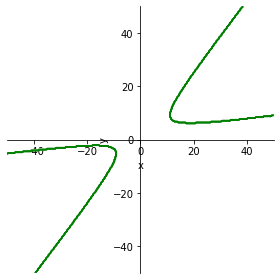

In [14]:
eq2 = Hyp1.equation(x='x', y='y')
dict_free = {str(a): a for a in eq2.free_symbols}

display(Hyp1.equation(x='x', y='y', _slope=sympy.tan(30 * sympy.pi / 180)))

p = plot_implicit(Hyp1.equation(x='x', y='y', _slope=sympy.tan(30 * sympy.pi / 180)),
                       (dict_free['x'], -50, 50), (dict_free['y'], -50, 50),
                  line_color='g', aspect_ratio=(1, 1),
                   show=False, adaptive=False)
p.show()

## Уравнения директрис и асимптот при повороте на угол $\alpha$
Пусть  $a$ - горизонтальная полуось, $c$ - фокусное расстояние, $x_0$ - горизонтальная координата центра гиперболы, тогда уравнение директрис 
$$
x = x_0 \pm \frac{a^2}{c}
$$
При повороте на угол $\alpha$ получается уравнение
$$
y = y_0 -{\rm ctg} \alpha(x - x_0) \pm \frac{a^2}{c}\sqrt{1 + {\rm ctg} \alpha}
$$
Уравнение асимптоты
$$
y = y_0 \pm \frac{b}{a}(x - x_0)
$$
При повороте на угол $\alpha$ получаются уравнения
\begin{align*}
y_1 = y_0 + k_1(x - x_0), \quad 
y_2 = y_0 + k_2(x - x_0), \\ 
k_1 = \frac{b + a{\rm tg} \alpha}{a - b{\rm tg} \alpha},\quad 
k_2 = \frac{-b + a{\rm tg} \alpha}{a + b{\rm tg} \alpha}
\end{align*}
### Задание 4.
Изобразить гиперболу Задания 3 (т.е. повернутую на угол) и ее асимптоты и директрисы на одном графике plot_implicit.

In [15]:
def get_new_asymptotes(center, a, b, alpha):
    as1 = center.y + (a + b * sympy.tan(alpha)) / (b - a * sympy.tan(alpha)) * (Symbol('x') - center.x)
    as2 = center.y + (-a + b * sympy.tan(alpha)) / (b + a * sympy.tan(alpha)) * (Symbol('x') - center.x)
    asympt1 = Eq(Symbol('y') - as1, 0)
    asympt2 = Eq(Symbol('y') - as2, 0)
    return [asympt1, asympt2]

def get_new_directrix(center, a, c, alpha):
    dr1 = center.y - 1 / sympy.tan(alpha) * (Symbol('x') - center.x) + a ** 2 / c * sympy.sqrt(1 + 1 / sympy.tan(alpha))
    dr2 = center.y - 1 / sympy.tan(alpha) * (Symbol('x') - center.x) - a ** 2 / c * sympy.sqrt(1 + 1 / sympy.tan(alpha))
    dir1 = Eq(Symbol('y') - dr1, 0)
    dir2 = Eq(Symbol('y') - dr2, 0)
    return [dir1, dir2]

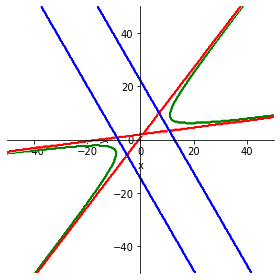

In [16]:
eq2 = Hyp1.equation(x='x', y='y')

dict_free = {str(a): a for a in eq2.free_symbols}

graph = plot_implicit(Hyp1.equation(x='x', y='y', _slope=sympy.tan(30 * sympy.pi / 180)),
                       (dict_free['x'], -50, 50), (dict_free['y'], -50, 50),
                  line_color='g', aspect_ratio=(1, 1),
                   show=False, adaptive=False)

new_asymptotes = get_new_asymptotes(Hyp1.center, Hyp1.minor, Hyp1.major, 30 * sympy.pi / 180)
new_directrix = get_new_directrix(Hyp1.center, Hyp1.major, Hyp1.focus_distance, 30 * sympy.pi / 180)

for equat in new_asymptotes:
   graph.extend(plot_implicit(equat,
                       ('x', -50, 50), ('y', -50, 50),
                  line_color='r', aspect_ratio=(1, 1),
                   show=False, adaptive=False))
   
for equat in new_directrix:
   graph.extend(plot_implicit(equat,
                       ('x', -50, 50), ('y', -50, 50),
                  line_color='b', aspect_ratio=(1, 1),
                   show=False, adaptive=False))

graph.show()

###  Индивидуальное задание
Определить гиперболу с центром в $(X, Y)$, полуосями $a$ и $b$.  Вывести на экран эксцентриситет, фокусное расстояние, фокусы (с координатами), periapsis, уравнение гиперболы, уравнения асимптот и директрис. 

Изобразить гиперболу, повернутую на $\alpha$ градусов против часовой стрелки относительно ее центра, соответствующие асимптоты и директрисы. Вывести на экран уравнение повернутой гиперболы.

эксцентриситет: 17/9
фокусное расстояние: 68/9
фокусы: (Point2D(-50/9, -1), Point2D(86/9, -1))
periapsis: 32/9
Асимптоты:


Eq(y, 4*sqrt(13)*(x - 2)/9 - 1)

Eq(y, -4*sqrt(13)*(x - 2)/9 - 1)


Директрисы:


Eq(x, 70/17)

Eq(x, -2/17)

Eq((x/4 - 1/2)**2 - 81*(y + 1)**2/3328, 1)

3*(x + sqrt(3)*(y + 1)/3 - 2)**2/64 - 243*(y - sqrt(3)*(x - 2)/3 + 1)**2/13312 - 1

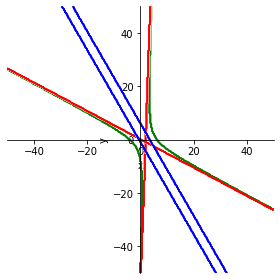

In [35]:
#Вариант N 126
#Центр $Point2D\left(2, -1\right)$, горизонтальная полуось $4$, эксцентриситет $17 / 9$, угол поворота $\pi / 3$, против часовой стрелки.
x, y = sympy.symbols('x y')
Hyp5 = Hyperbola(Point(2, -1), hradius = 4, eccentricity = S(17)/9)

x, y = sympy.symbols('x y')
print(f'эксцентриситет: {Hyp5.eccentricity}')
print(f'фокусное расстояние: {Hyp5.focus_distance}')
print(f'фокусы: {Hyp5.foci}')
print(f'periapsis: {Hyp5.periapsis}')
print('Асимптоты:')
display(*Hyp5.asymptote(equation=True))
print('\nДиректрисы:')
display(*Hyp5.directrix(equation=True))
display(Hyp5.equation(equation=True))


print('\n')

eq5 = Hyp5.equation(x='x', y='y')
dict_free = {str(a): a for a in eq5.free_symbols}

display(Hyp5.equation(x='x', y='y', _slope=sympy.tan(30 * sympy.pi / 180)))

new_asymptotes = get_new_asymptotes(Hyp5.center, Hyp5.minor, Hyp5.major, 30 * sympy.pi / 180)
new_directrix = get_new_directrix(Hyp5.center, Hyp5.major, Hyp5.focus_distance, 30 * sympy.pi / 180)

graph = plot_implicit(Hyp5.equation(x='x', y='y', _slope=sympy.tan(30 * sympy.pi / 180)),
                       (dict_free['x'], -50, 50), (dict_free['y'], -50, 50),
                  line_color='g', aspect_ratio=(1, 1),
                   show=False, adaptive=False)

for equat in new_asymptotes:
   graph.extend(plot_implicit(equat,
                       ('x', -50, 50), ('y', -50, 50),
                  line_color='r', aspect_ratio=(1, 1),
                   show=False, adaptive=False))
   
for equat in new_directrix:
   graph.extend(plot_implicit(equat,
                       ('x', -50, 50), ('y', -50, 50),
                  line_color='b', aspect_ratio=(1, 1),
                   show=False, adaptive=False))

graph.show()